In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sys, os

sys.path.append(os.path.abspath(os.path.join('..', 'utils')))

from data import select_features

df = pd.read_csv("../data/processed/train.csv",sep=",")

X = select_features(df)
y = df["pollutant"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Probamos un SVM lineal

In [5]:
from sklearn.svm import LinearSVC

svc1 = LinearSVC(C=2, loss='hinge', max_iter=5000)
svc1.fit(X_train, y_train);

/Users/jagudo/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [6]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

y_hat = svc1.predict(X_test)
acc = accuracy_score(y_true=y_test, y_pred=y_hat)
f1_s = f1_score(y_true=y_test, y_pred=y_hat, average='macro')

print('Primer modelo entrenado (SVM lineal)')
print(f'Accuracy: {acc}')
print(f'F1 Score: {f1_s}')

Primer modelo entrenado (SVM lineal)
Accuracy: 0.6140089418777943
F1 Score: 0.6237862045417008


## Creamos el fichero de soluciones generado por nuestro modelo para enviar a Kaggle

In [8]:
import kaggle as kg

X_sub = kg.generate_submision_df(X_train.columns)
kg.generate_submission_file(svc1, X_sub, 10)

# Entrenamos varias pipelines que contienen modelos de regresión logística, random forest y SVM con hiperparámetros

In [9]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC


reg_log = Pipeline(steps=[
                          ("imputer",SimpleImputer()),
                          ("scaler",StandardScaler()),
                          ("reglog",LogisticRegression())
                         ])

rand_forest = Pipeline(steps=[
                              ("randforest", RandomForestClassifier())
                             ])

svm = Pipeline(steps=[("scaler",StandardScaler()),
                      ("selectkbest",SelectKBest()),
                      ("svm",SVC())])

reg_log_param = {    
                 "imputer__strategy": ['mean', 'median', 'most_frequent'],
                 "reglog__penalty": ["none", "l1","l2", "elasticnet"], 
                 "reglog__solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
                 "reglog__C": [0.1, 1, 10, 100, 1000],
                 "reglog__max_iter": [100, 500, 1000] 
                }

rand_forest_param = {
    'randforest__n_estimators': [10, 100, 1000],
    'randforest__max_depth': [3, 6, 10, 15],
    'randforest__min_samples_leaf': [10, 20, 30],
    'randforest__max_features': [1, 2, 3, 10, 15, 30]
    }

svm_param = {                    
            'selectkbest__k': [1,2,3],
            'svm__C': [0.1, 1, 10, 100, 1000], 
            'svm__kernel': ["linear","poly","rbf"],
            'svm__coef0': [-10.,-1., 0., 0.1, 0.5, 1, 10, 100],
            'svm__gamma': ('scale', 'auto')
            }

gs_reg_log = GridSearchCV(reg_log,
                            reg_log_param,
                            cv=10,
                            scoring="f1_macro",
                            verbose=1,
                            n_jobs=-1)

gs_rand_forest = GridSearchCV(rand_forest,
                            rand_forest_param,
                            cv=10,
                            scoring="f1_macro",
                            verbose=1,
                            n_jobs=-1)

gs_svm = GridSearchCV(svm,
                        svm_param,
                        cv=10,
                        scoring="f1_macro",
                        verbose=1,
                        n_jobs=-1)

grids = {"gs_reg_log":gs_reg_log,
         "gs_rand_forest":gs_rand_forest,
         "gs_svm":gs_svm}

In [10]:
%%time

for nombre, grid_search in grids.items():
    grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 900 candidates, totalling 9000 fits


/Users/jagudo/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
4050 fits failed out of a total of 9000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jagudo/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jagudo/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jagudo/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/linear_mode

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
Fitting 10 folds for each of 720 candidates, totalling 7200 fits
CPU times: user 2min 40s, sys: 17.4 s, total: 2min 58s
Wall time: 16h 29min 56s


In [11]:
best_grids = [(i, j.best_score_) for i, j in grids.items()]

best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
best_grids

,Grid,Best score
0,gs_reg_log,0.646944
1,gs_rand_forest,0.640585
2,gs_svm,0.547912


In [12]:
print('El mejor modelo ha sido:')
best_model = grids["gs_reg_log"]
best_model

El mejor modelo ha sido:


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('reglog', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'imputer__strategy': ['mean', 'median',
                                               'most_frequent'],
                         'reglog__C': [0.1, 1, 10, 100, 1000],
                         'reglog__max_iter': [100, 500, 1000],
                         'reglog__penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'reglog__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                            'sag', 'saga']},
             scoring='f1_macro', verbose=1)

In [13]:
mejor_modelo = best_model.best_estimator_
mejor_modelo

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('reglog', LogisticRegression(C=10, solver='liblinear'))])

## Calculamos F1 score para el mejor modelo encontrado con nuestro conjunto de datos de test

In [14]:
y_hat = mejor_modelo.predict(X_test)
f1_s = f1_score(y_true=y_test, y_pred=y_hat, average='macro')
print('Evaluando el mejor modelo encontrado utilizando datos de test')
print(f'F1 Score: {f1_s}')

Evaluando el mejor modelo encontrado utilizando datos de test
F1 Score: 0.6426717615808774


# Analizamos cómo de bueno es nuestro mejor modelo encontrado

## Mostramos la matriz de confusión del modelo para ver cómo de efectivo es

/Users/jagudo/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  "X does not have valid feature names, but"


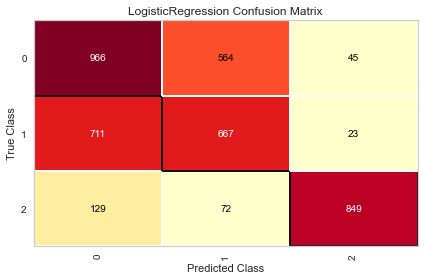

In [15]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(mejor_modelo)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show();

## Visualizamos la curva ROC AUC del modelo

/Users/jagudo/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  "X does not have valid feature names, but"


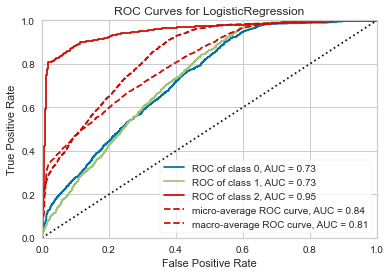

In [16]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(mejor_modelo)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

## Visualizamos la curva Precision-Recall del modelo

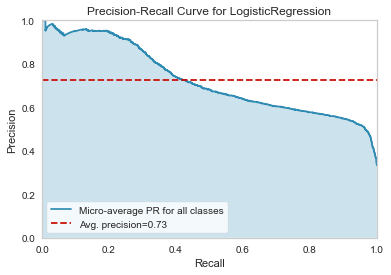

In [17]:
from yellowbrick.classifier import PrecisionRecallCurve

viz = PrecisionRecallCurve(mejor_modelo)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show();

Vemos que el modelo es realmente bueno al predecir Methane (CH4) con las otras dos clases (clase 0 y clase 1) comete más fallos.

Generamos ahora el fichero con la solución para evaluación en Kaggle utilizando nuestro mejor modelo.

In [19]:
kg.generate_submission_file(mejor_modelo, X_sub, 12)

# Analizamos el segundo mejor modelo que hemos encontrado

Con Random Forest, teníamos un F1 score muy cercano al modelo de regresión logística, por lo que vamos a estudiar las características de ese modelo.

## Mostramos la matriz de confusión del modelo para ver cómo de efectivo es

/Users/jagudo/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


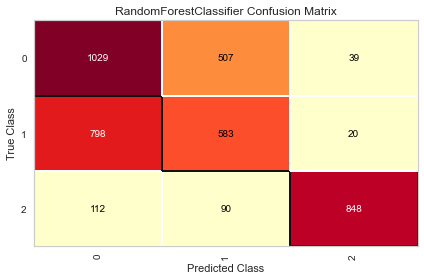

In [20]:
mejor_random_forest = grids['gs_rand_forest'].best_estimator_

cm = ConfusionMatrix(mejor_random_forest)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show();

## Visualizamos la curva ROC AUC del modelo

/Users/jagudo/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


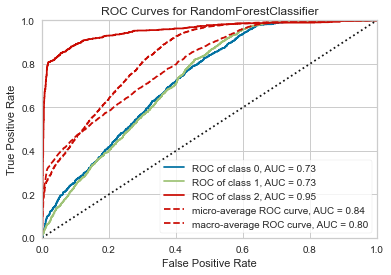

In [21]:
visualizer = ROCAUC(mejor_random_forest)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

## Visualizamos la curva Precision-Recall del modelo

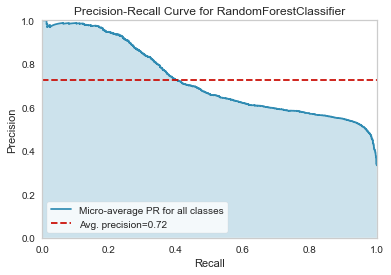

In [22]:
viz = PrecisionRecallCurve(mejor_random_forest)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show();

Aunque nuestro mejor modelo generado con random forest tiene un F1 score muy similar al mejor modelo generado con regresión logística, podemos ver que el random forest acierta un poco más al predecir Methane (CH4), pero falla más con los otros dos contaminantes. Por lo tanto, podemos decir que es menos generalista que el otro modelo.

Generamos ahora el fichero con la solución para evaluación en Kaggle utilizando el mejor random forest que hemos obtenido.

In [23]:
kg.generate_submission_file(mejor_random_forest, X_sub, 13)

# Resultado final en Kaggle

Al hacer submit en Kaggle, vemos que el modelo de random forest tiene un mejor score, pese a que al calcular nosotros el F1 score nos salía que el modelo con regresión logística era mejor.

Analizando los valores predichos por ambos modelos y viendo el número de ocurrencias de *Methane (CH4)* (valor 2), vemos que el modelo de regresión logística predice más ocurrencias:

In [24]:
mejor_modelo.predict(X_sub).tolist().count(2)

3882

In [25]:
mejor_random_forest.predict(X_sub).tolist().count(2)

3817

Precisamente para Methane (CH4) (valor 2), el modelo de random forest hace mejores predicciones, lo que explica que para este conjunto de datos precisamente funcione mejor y, por lo tanto, tenga un score mejor en Kaggle.